In [3]:
# notebook settings
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# external imports
import numpy as np
import sympy as sp
# from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt

# internal imports
from nonlinear_dynamics import simulate
from mld_dynamics import mld, h
from warm_start_hmpc.controller import HybridModelPredictiveController
from warm_start_hmpc.mcais import mcais, solve_dare
from visualizer import vis, animate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [4]:
# controller horizon
T = 20

# weight matrices
C = np.eye(mld.nx) * h
D = np.vstack([1.]+[0.]*(mld.nu - 1)).T * h

# # terminal cost
# Bu = mld.B[:,0:1]
# Du = D[:,0:1]
# P = solve_discrete_are(mld.A, Bu, C.T.dot(C), Du.T.dot(Du))
# C_T = np.linalg.cholesky(P).T
# C_T = C
# objective = [C, D, C_T]

# # terminal constraints
# F_T = np.vstack((np.eye(mld.nx), - np.eye(mld.nx)))
# h_T = np.concatenate((x_max, x_max))
# terminal_set = [F_T, h_T]

In [7]:
from pympc.dynamics.discrete_time_systems import LinearSystem
from pympc.geometry.polyhedron import Polyhedron

# LQR cost to go
Bu = mld.B[:,0:1]
Du = D[:,0:1]
P, K = solve_dare(mld.A, Bu, C.dot(C), Du.dot(Du))
C_T = np.linalg.cholesky(P).T
objective = [C, D, C_T]

# # mcais terminal set
# domain = Polyhedron(
#     np.hstack((mld.F, mld.G[:,0:1])),
#     mld.h
# )
# X_T = S.mcais(K, domain, verbose=True)
# terminal_set = [X_T.A, X_T.b]

In [8]:
A_cl = mld.A + Bu.dot(K)
lhs = mld.F + mld.G[:,0:1].dot(K)
rhs = mld.h
terminal_set = mcais(A_cl, lhs, rhs, verbose=True)

Academic license - for non-commercial use only
Time horizon: 34. Convergence index: 0.000000. Number of facets: 162.
Maximal constraint-admissible invariant set found. Removing redundant facets ... minimal facets are 102.


In [9]:
# hybrid controller
controller = HybridModelPredictiveController(mld, T, objective, terminal_set)

# initial push towards the right wall
x0 = np.array([0., 0., 1., 0.])

## Open-loop solution

In [11]:
# solve in open loop
solution, leaves = controller.feedforward(
    x0,
    draw_label='Cart pole with walls'
)[:2]

|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.04            1               4.266e-02       inf             
                 3.04            81              5.918e-02       inf             
                 6.04            154             6.126e-02       inf             
 New incumbent   6.27            160             6.926e-02       6.926e-02       
 Solution found  6.27            160             6.926e-02       6.926e-02       

Explored 160 nodes in 6.270 seconds: optimal solution found with cost 6.926e-02.


In [7]:
x_gurobi, obj_gurobi = controller.feedforward_gurobi(x0)

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Optimize a model with 894 rows, 224 columns and 2608 nonzeros
Model has 110 quadratic objective terms
Variable types: 144 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [6e-04, 2e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 611 rows and 78 columns
Presolve time: 0.02s
Presolved: 283 rows, 146 columns, 1273 nonzeros
Presolved model has 104 quadratic objective terms
Variable types: 111 continuous, 35 integer (35 binary)

Root relaxation: objective 5.679353e-02, 445 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.05679    0   26          -    0.05679      -     -    0s
     0     0    0.05679    0   26          -    0.0567

In [12]:
vis.jupyter_cell()

In [13]:
animate(solution.variables['x'], h)

## Solve with and without warm start

In [11]:
e0 = np.random.randn(mld.nx) * 0.
uc0 = solution.variables['uc'][0]
ub0 = solution.variables['ub'][0]
warm_start = controller.construct_warm_start(leaves, x0, uc0, ub0, e0)

In [12]:
u0 = np.concatenate((uc0, ub0))
x1 = mld.A.dot(x0) + mld.B.dot(u0) + e0
solution, leaves = controller.feedforward(
    x1,
    warm_start=warm_start,
#     draw_label='Cart pole with walls warm start'
)

Loaded warm start with 93 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.83            25              5.391e-02       5.391e-02       
 Solution found  0.83            25              5.391e-02       5.391e-02       

Explored 25 nodes in 0.835 seconds: optimal solution found with cost 5.391e-02.


In [13]:
solution, leaves = controller.feedforward(x1)

|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.03            1               3.931e-02       inf             
                 3.05            99              5.376e-02       inf             
                 6.07            183             5.391e-02       inf             
 New incumbent   6.30            190             5.391e-02       5.391e-02       
 Solution found  6.30            190             5.391e-02       5.391e-02       

Explored 190 nodes in 6.304 seconds: optimal solution found with cost 5.391e-02.


## Solve in closed loop

In [14]:
from visualizer import vis, visualize
vis.jupyter_cell()

In [24]:
# np.random.seed(1)

# set up simulation
T_sim = 60
x_true = [x0]
x_sim = []
x_predicted = []
u_sim = []
warm_start = None

for t in range(T_sim):
    print('Time step %d.'%t)
    
    # solve miqp
    solution, leaves = controller.feedforward(
        x_true[-1],
        warm_start=warm_start,
#         printing_period=None
    )[:2]
    
    # reorganize solution
    uc0 = solution.variables['uc'][0]
    ub0 = solution.variables['ub'][0]
    u0 = np.concatenate((uc0, ub0))
    x_sim_t = simulate(x_true[-1], h, uc0[0])
    x1 = x_sim_t[-1]
#     x1 = solution.variables['x'][1]
    e0 = x1 - mld.A.dot(x_true[-1]) - mld.B.dot(u0)
    print('predicted state:', solution.variables['x'][1])
    print('true state:', x1)
    print('modeling error:', e0)
#     visualize(x1)
    
    # generate warm start
    warm_start = controller.construct_warm_start(leaves, x_true[-1], uc0, ub0, e0)
    
    # retrieve closed-loop trajectory
#     x_sim.append(x1)
    u_sim.append(uc0)
    
    # retrieve closed-loop trajectory
    x_predicted.append(solution.variables['x'][1])
    x_true.append(x1)
    x_sim.extend(x_sim_t)

Time step 0.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.05            1               4.266e-02       inf             
                 3.10            59              5.817e-02       inf             
                 6.11            135             6.114e-02       inf             
 New incumbent   7.03            160             6.926e-02       6.926e-02       
 Solution found  7.03            160             6.926e-02       6.926e-02       

Explored 160 nodes in 7.026 seconds: optimal solution found with cost 6.926e-02.
predicted state: [ 0.05  0.    0.95 -0.05]
true state: [ 0.04877269 -0.00122961  0.94980362 -0.0503928 ]
modeling error: [-0.00122731 -0.00122961 -0.00019638 -0.0003928 ]
Time step 1.
Loaded warm start with 77 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper boun

                 3.02            71              2.272e-02       inf             
 New incumbent   5.57            129             2.794e-02       2.794e-02       
 Solution found  5.62            130             2.794e-02       2.794e-02       

Explored 130 nodes in 5.621 seconds: optimal solution found with cost 2.794e-02.
predicted state: [ 0.39574007 -0.18629597  0.16268164  0.40621593]
true state: [ 0.39442328 -0.18064605  0.15696207  0.32474631]
modeling error: [-0.00131678  0.00564993 -0.00571956 -0.08146962]
Time step 13.
Loaded warm start with 131 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
                 3.03            72              1.752e-02       inf             
                 6.04            140             2.785e-02       inf             
 New incumbent   6.98            162             3.054e-02      

Time step 23.
Loaded warm start with 559 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   2.05            56              3.028e-02       3.028e-02       
 Solution found  2.05            56              3.028e-02       3.028e-02       

Explored 56 nodes in 2.052 seconds: optimal solution found with cost 3.028e-02.
predicted state: [ 0.45048503 -0.02232504  0.10074189  0.14381027]
true state: [ 0.45023435 -0.02292138  0.10278464  0.14785303]
modeling error: [-0.00025068 -0.00059635  0.00204275  0.00404276]
Time step 24.
Loaded warm start with 577 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   1.52            42              2.956e-02    

 New incumbent   0.67            19              2.111e-02       2.111e-02       
 Solution found  0.67            19              2.111e-02       2.111e-02       

Explored 19 nodes in 0.670 seconds: optimal solution found with cost 2.111e-02.
predicted state: [ 0.46487169  0.01081347 -0.04642474  0.00379669]
true state: [ 0.46463916  0.01070984 -0.04634105  0.00396386]
modeling error: [-2.32523513e-04 -1.03636019e-04  8.36923597e-05  1.67171453e-04]
Time step 36.
Loaded warm start with 224 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.72            20              2.033e-02       2.033e-02       
 Solution found  0.75            21              2.033e-02       2.033e-02       

Explored 21 nodes in 0.754 seconds: optimal solution found with cost 2.033e-02.
predicted state: [ 0.46232211  0.01090803 -0.05517

 New incumbent   0.58            14              1.319e-02       1.319e-02       
 Solution found  0.58            14              1.319e-02       1.319e-02       

Explored 14 nodes in 0.576 seconds: optimal solution found with cost 1.319e-02.
predicted state: [ 0.41238521  0.00666576 -0.11661112 -0.01016154]
true state: [ 0.4123017   0.00666826 -0.11673829 -0.01041585]
modeling error: [-8.35056797e-05  2.50320840e-06 -1.27175309e-04 -2.54312778e-04]
Time step 48.
Loaded warm start with 89 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.57            14              1.266e-02       1.266e-02       
 Solution found  0.57            14              1.266e-02       1.266e-02       

Explored 14 nodes in 0.570 seconds: optimal solution found with cost 1.266e-02.
predicted state: [ 0.40646479  0.00614747 -0.119726

 New incumbent   0.44            11              8.003e-03       8.003e-03       
 Solution found  0.47            12              8.003e-03       8.003e-03       

Explored 12 nodes in 0.475 seconds: optimal solution found with cost 8.003e-03.
predicted state: [ 0.3346497   0.00125275 -0.13623843 -0.007017  ]
true state: [ 0.33464084  0.00126239 -0.13632901 -0.00719815]
modeling error: [-8.85696812e-06  9.64569226e-06 -9.05745443e-05 -1.81144818e-04]


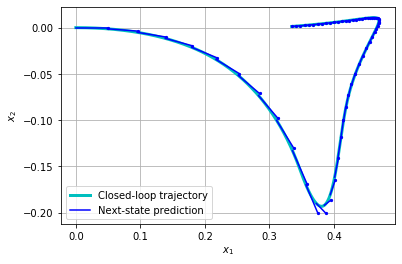

In [27]:
indices =  [0,1]
fig = plt.figure()

plt.plot(
    [xt[indices[0]] for xt in x_sim],
    [xt[indices[1]] for xt in x_sim],
    color='c',
    label='Closed-loop trajectory',
    linewidth=3
)

for t in range(T_sim):
    label = 'Next-state prediction'
    if t > 0:
        label=None
    plt.plot(
        [x_true[t][indices[0]], x_predicted[t][indices[0]]],
        [x_true[t][indices[1]], x_predicted[t][indices[1]]],
        c='b',
        label=label
    )
    plt.scatter(
        [x_predicted[t][indices[0]]],
        [x_predicted[t][indices[1]]],
        c='b',
        marker='o',
        s=5,
        zorder=3
    )
plt.xlabel(r'$x_%d$'%(indices[0]+1))
plt.ylabel(r'$x_%d$'%(indices[1]+1))
# ax.set_zlabel(r'Solved QPs')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig('error_soft.pdf')

## Animation

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
animate(x_sim, h)